In [6]:
%cd /content/drive/MyDrive/MLCB/Project/Data

/content/drive/MyDrive/MLCB/Project/Data


In [7]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import json
import networkx as nx
import numpy as np
import pickle
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
# !pip install --upgrade torch

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
events_extract = pd.read_csv("events_extract.csv")

In [10]:
events_extract = events_extract.drop(columns=["Unnamed: 0","interaction","action"],index=None)

In [11]:
events_extract

,Unnamed: 0.1,index,id1,name1,id2,name2,mechanism,label
0,0,0,DB12001,Abemaciclib,DB01118,Amiodarone,The risk or severity of adverse effects,0
1,1,1,DB12001,Abemaciclib,DB11901,Apalutamide,The serum concentration,1
2,2,2,DB12001,Abemaciclib,DB00673,Aprepitant,The serum concentration,1
3,3,3,DB12001,Abemaciclib,DB00289,Atomoxetine,The metabolism,2
4,4,4,DB12001,Abemaciclib,DB00188,Bortezomib,The metabolism,2
...,...,...,...,...,...,...,...,...
37259,37259,37259,DB01149,Nefazodone,DB09048,Netupitant,The serum concentration,1
37260,37260,37260,DB01149,Nefazodone,DB00622,Nicardipine,The metabolism,2
37261,37261,37261,DB11828,Neratinib,DB09048,Netupitant,The serum concentration,1
37262,37262,37262,DB09048,Netupitant,DB00622,Nicardipine,The serum concentration,1


In [18]:
def load_graph2seq_features(filepath):
    """Load graph2seq features dictionary from a file."""
    with open(filepath, 'rb') as f:
        features = pickle.load(f)
    return features
graph2seq_features = load_graph2seq_features("drug_embeddings_vae.pkl")

In [19]:
from torch.utils.data import Dataset

class DDIDataset(Dataset):
    def __init__(self, ddi_df, graph2seq_features):
        self.ddi_df = ddi_df
        self.graph2seq_features = graph2seq_features

    def __len__(self):
        return len(self.ddi_df)

    def __getitem__(self, idx):
        row = self.ddi_df.iloc[idx]
        id1 = row['id1']
        id2 = row['id2']
        label = row['label']

        seq1 = torch.tensor(self.graph2seq_features[id1], dtype=torch.float32).unsqueeze(-1)
        seq2 = torch.tensor(self.graph2seq_features[id2], dtype=torch.float32).unsqueeze(-1)

        return seq1, seq2, label


In [20]:


class BiRNN_DDI_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiRNN_DDI_Model, self).__init__()

        self.bigru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        self.mlp = nn.Sequential(
            nn.Linear(4*hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def encode(self, x):
        output, _ = self.bigru(x)
        pooled_output = torch.mean(output, dim=1)
        return pooled_output

    def forward(self, seq1, seq2):
        emb1 = self.encode(seq1)
        emb2 = self.encode(seq2)
        concat_emb = torch.cat((emb1, emb2), dim=-1)
        out = self.mlp(concat_emb)
        return out


In [ ]:
# import torch
# import torch.nn as nn

# class BiRNN_DDI_Model(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(BiRNN_DDI_Model, self).__init__()

#         self.bigru = nn.GRU(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True
#         )

#         self.mlp = nn.Sequential(
#             nn.Linear(4*hidden_size, 512),
#             nn.BatchNorm1d(512),  # Normalization added here
#             nn.ReLU(),
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),  # Normalization added here
#             nn.ReLU(),
#             nn.Linear(256, num_classes)
#         )

#     def encode(self, x):
#         output, _ = self.bigru(x)
#         pooled_output = torch.mean(output, dim=1)
#         return pooled_output

#     def forward(self, seq1, seq2):
#         emb1 = self.encode(seq1)
#         emb2 = self.encode(seq2)
#         concat_emb = torch.cat((emb1, emb2), dim=-1)
#         out = self.mlp(concat_emb)
#         return out


In [21]:

def get_kfold_splits_with_test(dataset, k=7):
    """
    Split dataset into k folds for Train/Validation and reserve one fold for Test.
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    labels = [dataset[i][2] for i in range(len(dataset))]

    splits = list(skf.split(np.zeros(len(labels)), labels))

    # Use the last fold as Test set
    train_val_splits = splits[:-1]
    test_split = splits[-1]

    return train_val_splits, test_split


In [22]:
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, device, epochs=80, patience=10, fold=0):
    model = model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # ----------------- Training -----------------
        model.train()
        running_train_loss = 0
        correct_train = 0
        total_train = 0

        for seq1, seq2, labels in train_loader:
            seq1, seq2, labels = seq1.to(device), seq2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(seq1, seq2)
            loss = criterion(outputs, labels)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)

        # ----------------- Validation -----------------
        model.eval()
        running_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for seq1, seq2, labels in val_loader:
                seq1, seq2, labels = seq1.to(device), seq2.to(device), labels.to(device)
                outputs = model(seq1, seq2)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)

        # ----------------- Print -----------------
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # ----------------- Save Best Model -----------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()

            # Save best model checkpoint
            torch.save(best_model_state, f"best_model_fold{fold}.pth")
        else:
            patience_counter += 1

        # ----------------- Early Stopping -----------------
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

    # ----------------- Final Test Evaluation -----------------
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pth"))
    model.eval()

    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for seq1, seq2, labels in test_loader:
            seq1, seq2, labels = seq1.to(device), seq2.to(device), labels.to(device)
            outputs = model(seq1, seq2)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_loss = test_loss / len(test_loader)
    test_acc = correct_test / total_test

    print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

    # ----------------- Plot Train/Val Loss -----------------
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Validation Loss (Fold {fold})')
    plt.legend()
    plt.grid()
    plt.show()



Training Fold 1
Epoch 1/30 | Train Loss: 1.9531 | Train Acc: 0.4752 | Val Loss: 1.8065 | Val Acc: 0.4771
Epoch 2/30 | Train Loss: 1.8025 | Train Acc: 0.4771 | Val Loss: 1.8001 | Val Acc: 0.4771
Epoch 3/30 | Train Loss: 1.8004 | Train Acc: 0.4771 | Val Loss: 1.7984 | Val Acc: 0.4771
Epoch 4/30 | Train Loss: 1.8008 | Train Acc: 0.4771 | Val Loss: 1.7985 | Val Acc: 0.4771
Epoch 5/30 | Train Loss: 1.7995 | Train Acc: 0.4771 | Val Loss: 1.8000 | Val Acc: 0.4771
Epoch 6/30 | Train Loss: 1.7992 | Train Acc: 0.4771 | Val Loss: 1.7963 | Val Acc: 0.4771
Epoch 7/30 | Train Loss: 1.8007 | Train Acc: 0.4771 | Val Loss: 1.7947 | Val Acc: 0.4771
Epoch 8/30 | Train Loss: 1.7990 | Train Acc: 0.4771 | Val Loss: 1.8025 | Val Acc: 0.4771
Epoch 9/30 | Train Loss: 1.7981 | Train Acc: 0.4771 | Val Loss: 1.8036 | Val Acc: 0.4771
Epoch 10/30 | Train Loss: 1.7972 | Train Acc: 0.4771 | Val Loss: 1.7965 | Val Acc: 0.4771
Early stopping triggered at epoch 10!

Final Test Loss: 1.7960 | Final Test Acc: 0.4771


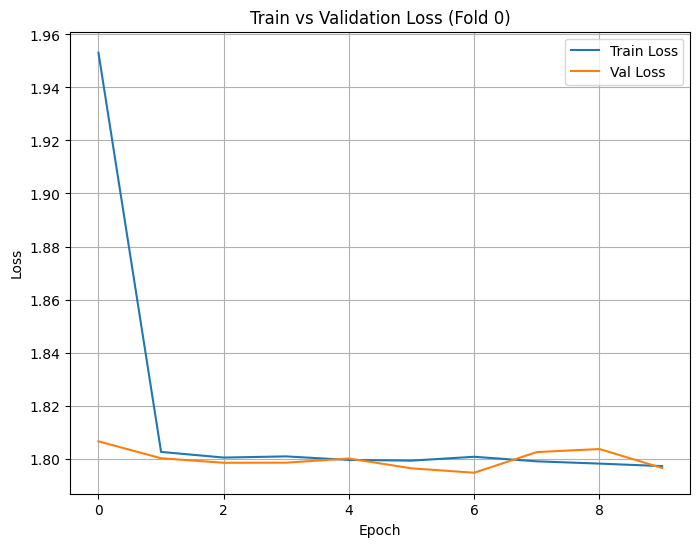

In [23]:
# Create the dataset
ddi_dataset = DDIDataset(events_extract, graph2seq_features)

# Get Train/Val splits and Test split
train_val_splits, test_split = get_kfold_splits_with_test(ddi_dataset, k=2)

# Build Test Loader once
test_loader = DataLoader(Subset(ddi_dataset, test_split[1]), batch_size=32, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(train_val_splits):
    print(f"\nTraining Fold {fold+1}")

    # Create Train and Validation Loaders
    train_loader = DataLoader(Subset(ddi_dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(ddi_dataset, val_idx), batch_size=32, shuffle=False)

    # Initialize a fresh model for each fold
    model = BiRNN_DDI_Model(
        input_size=1,  # Because each graph2seq position is 1D
        hidden_size=256,
        num_classes=len(events_extract['label'].unique())
    )
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Train model with train_loader, val_loader, test_loader
    train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, device, epochs=30, patience=3)
